# <u>Grid search over River Discharge Dataset</u>

This grid search identifies optimal hyperparameter configurations through a chronological train-validation split. For each candidate configuration, models are trained with early stopping based on validation performance. The best-performing hyperparameter set within each model class is retained for subsequent test set evaluation. Schonau_Q serves as the target variable, predicted using lagged input features $\tilde{x}_t$ with a lag window of s=10 time steps.

Note: The grid search of few models have been separated from the rest due to the high computational cost.


### <u>Import libraries, modules and models </u>

In [1]:
# Import main libraries
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set current and repository working directory
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import custom modules
from Modules.Train_Val_Grid import *

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### <u>Import dataset:</u>

In [2]:
# Import dataset and split into train-validation and test sets
df = pd.read_csv("../River_Discharge_Study/tilde_X.csv", index_col=0, parse_dates=True)
df_train_val = df[:10349]
df_test = df[10349:]
lag=10
feature=df.shape[1]
val_size = 0.25
batch_size = 256


In [3]:
df_train_val.head(2)

,Gsteig_Q,BEP,GHS,THU,LTB,BRZ,MER,Schonau_Q
Date,,,,,,,,
1930-01-01,3.6,0.0,0.0,0.0,0.8,1.3,0.5,46.1
1930-01-02,3.6,3.2,0.5,2.3,1.0,3.4,3.2,46.1


In [4]:
df_train_val.tail(2)

,Gsteig_Q,BEP,GHS,THU,LTB,BRZ,MER,Schonau_Q
Date,,,,,,,,
1958-05-01,19.3,0.0,0.0,0.0,0.0,0.0,0.0,137.0
1958-05-02,23.9,0.0,0.0,0.0,0.0,0.0,0.0,148.0


In [5]:
df_test.tail(2)

,Gsteig_Q,BEP,GHS,THU,LTB,BRZ,MER,Schonau_Q
Date,,,,,,,,
2014-12-30,4.061,1.6,2.6,2.3,2.7,3.0,2.7,44.834
2014-12-31,4.024,0.0,0.0,0.0,0.0,0.0,0.0,44.774


## <u> Model Classes and Hyperparameter Spaces </u>

### <u> MLP configurations </u>

In [6]:
mlp_base_config = {
    "input_size": lag * feature,
    "output_size": 1
}

mlp_search_space = {
    "mlp_hidden_size": [64, 128, [64, 64], [128, 64], [64, 64, 64]]
}

mlp_param_grid = expand_param_grid(mlp_base_config, mlp_search_space)

### <u> Sequential MLP configurations </u>

In [7]:
sequential_mlp_base_config = {
    "input_size": feature,
    "output_size": 1,
    "sequence_length": lag
}

sequential_mlp_search_space = {
    "gru_hidden_size": [64, 128, [64, 64]],
    "mlp_hidden_size": [64, [32, 32], [64, 64]],
    "pooling": ["last", "static_softmax"]
}

sequential_mlp_param_grid = expand_param_grid(sequential_mlp_base_config, sequential_mlp_search_space)

### <u> Engression configurations </u>

In [8]:
engression_base_config = {
    "input_dim": lag * feature,
    "output_dim": 1
}

engression_search_space = {
    "mlp_hidden_dim": [64, 128, [64, 64], [128, 64], [64, 64, 64]],
    "mlp_sigma": [1.0],
    "mlp_noise_dim": [100]
}

engression_param_grid = expand_param_grid(engression_base_config, engression_search_space)

### <u> Heteroskedastic Engression configurations </u>

In [9]:
h_engression_base_config = {
    "input_dim": lag * feature,
    "output_dim": 1
}

h_engression_search_space = {
    "mlp_hidden_dim": [64, 128, [64, 64], [128, 64], [64, 64, 64]],
    "mlp_noise_dim": [100],
    "mlp_noise_representation": ["scalar", "vector"]
}

h_engression_param_grid = expand_param_grid(h_engression_base_config, h_engression_search_space)

### <u> Sequential Engression configurations </u>

In [10]:
sequential_engression_base_config = {
    "input_dim": feature,
    "output_dim": 1,
    "sequence_length": lag
}

sequential_engression_search_space = {
    "gru_hidden_size": [64, 128, [64, 64]],
    "mlp_hidden_dim": [64, [32, 32], [64, 64]],
    "mlp_sigma": [1.0],
    "mlp_noise_dim": [100],
    "pooling": ["last", "static_softmax"]
}

sequential_engression_param_grid = expand_param_grid(sequential_engression_base_config, sequential_engression_search_space)

### <u> Heteroskedastic Sequential configurations </u>

In [11]:
h_sequential_engression_base_config = {
    "input_dim": feature,
    "output_dim": 1,
    "sequence_length": lag
}

h_sequential_engression_search_space = {
    "gru_hidden_size": [64, 128, [64, 64]],
    "mlp_hidden_dim": [64, [32, 32], [64, 64]],
    "mlp_noise_dim": [100],
    "mlp_noise_representation": ["scalar", "vector"],
    "pooling": ["last", "static_softmax"]
}

h_sequential_engression_param_grid = expand_param_grid(h_sequential_engression_base_config, h_sequential_engression_search_space)

## <u> List of configurations MLP, Sequential MLP, Engression, H-Engression </u>

In [12]:
learning_rates = [1e-3, 5e-4]
weight_decays = [0.0, 1e-4]

all_configs = []

# 1. MLP Configurations (DETERMINISTIC)
for lr in learning_rates:
    for wd in weight_decays:
        config = {
            "name": "mlp",
            "param_grid": mlp_param_grid,
            "learning_rate": lr,
            "weight_decay": wd,
            "train_kw": {
                "num_epochs": 1000,
                "patience": 10,
                "delta": 5e-4,
                "early_stopping": True,
                "eval_every": 2,
                "verbose": False
            }
        }
        all_configs.append(config)


# 2. Sequential MLP Configurations (DETERMINISTIC)
for lr in learning_rates:
    for wd in weight_decays:
        config = {
            "name": "sequential_mlp",
            "param_grid": sequential_mlp_param_grid,
            "learning_rate": lr,
            "weight_decay": wd,
            "train_kw": {
                "num_epochs": 1000,
                "patience": 10,
                "delta": 5e-4,
                "early_stopping": True,
                "eval_every": 2,
                "verbose": False
            }
        }
        all_configs.append(config)

# 3. Engression Configurations (STOCHASTIC)
for lr in learning_rates:
    for wd in weight_decays:
        config = {
            "name": "engression",
            "param_grid": engression_param_grid,
            "learning_rate": lr,
            "weight_decay": wd,
            "train_kw": {
                "num_epochs": 1000,
                "patience": 15,
                "delta": 5e-4,
                "early_stopping": True,
                "eval_every": 2,
                "verbose": False,
                "m": 2,
                "m_validation": 50
            }
        }
        all_configs.append(config)


# 4. H_Engression Configurations (STOCHASTIC)
for lr in learning_rates:
    for wd in weight_decays:
        config = {
            "name": "h_engression",
            "param_grid": h_engression_param_grid,
            "learning_rate": lr,
            "weight_decay": wd,
            "train_kw": {
                "num_epochs": 1000,
                "patience": 15,
                "delta": 5e-4,
                "early_stopping": True,
                "eval_every": 2,
                "verbose": False,
                "m": 2,
                "m_validation": 50
            }
        }
        all_configs.append(config)





In [13]:
print("Configuration Summary:")
print("=" * 80)

# Calculate combinations per model type
mlp_combinations = len(mlp_param_grid) * len(learning_rates) * len(weight_decays)
sequential_mlp_combinations = len(sequential_mlp_param_grid) * len(learning_rates) * len(weight_decays)
engression_combinations = len(engression_param_grid) * len(learning_rates) * len(weight_decays)
h_engression_combinations = len(h_engression_param_grid) * len(learning_rates) * len(weight_decays)

total_configs = (mlp_combinations + sequential_mlp_combinations + engression_combinations +
                h_engression_combinations)

print(f"MLP: {mlp_combinations}")
print(f"Sequential MLP: {sequential_mlp_combinations}")
print(f"Engression: {engression_combinations}")
print(f"H_Engression: {h_engression_combinations}")
print("=" * 80)
print(f"Total parameter combinations: {total_configs}")
print(f"Using lag={lag}, features={feature}, batch_size={batch_size}")

# Calculate actual split sizes
train_samples = int(len(df_train_val) * (1 - val_size))
val_samples = len(df_train_val) - train_samples

print(f"Train samples: {train_samples}, Validation samples: {val_samples}, Test samples: {len(df_test)}")
print("=" * 80)

Configuration Summary:
MLP: 20
Sequential MLP: 72
Engression: 20
H_Engression: 40
Total parameter combinations: 152
Using lag=10, features=8, batch_size=256
Train samples: 7761, Validation samples: 2588, Test samples: 20697


In [14]:
# # Run the grid search
# results = run_chronological_grid_search(
#     configs = all_configs,
#     df = df_train_val,
#     lags = lag,
#     val_size = val_size,
#     batch_size = batch_size,
#     standardize = True,
#     device = device,
#     result_csv_path = "river_discharge.csv",
#     experiment_name = "_FIRST_PART",
#     seed = 1
# )

## <u> List of configurations sequential Engression </u>

In [15]:
learning_rates = [1e-3, 5e-4]
weight_decays = [0.0, 1e-4]

all_configs = []


# 5. Sequential Engression Configurations (STOCHASTIC)
for lr in learning_rates:
    for wd in weight_decays:
        config = {
            "name": "sequential_engression",
            "param_grid": sequential_engression_param_grid,
            "learning_rate": lr,
            "weight_decay": wd,
            "train_kw": {
                "num_epochs": 1000,
                "patience": 15,
                "delta": 5e-4,
                "early_stopping": True,
                "eval_every": 2,
                "verbose": False,
                "m": 2,
                "m_validation": 50
            }
        }
        all_configs.append(config)


In [16]:
print("Configuration Summary:")
print("=" * 80)

# Calculate combinations per model type
sequential_engression_combinations = len(sequential_engression_param_grid) * len(learning_rates) * len(weight_decays)
total_configs = (sequential_engression_combinations)
print(f"Sequential Engression: {sequential_engression_combinations}")
print("=" * 80)
print(f"Total parameter combinations: {total_configs}")
print(f"Using lag={lag}, features={feature}, batch_size={batch_size}")

# Calculate actual split sizes
train_samples = int(len(df_train_val) * (1 - val_size))
val_samples = len(df_train_val) - train_samples

print(f"Train samples: {train_samples}, Validation samples: {val_samples}, Test samples: {len(df_test)}")
print("=" * 80)

Configuration Summary:
Sequential Engression: 72
Total parameter combinations: 72
Using lag=10, features=8, batch_size=256
Train samples: 7761, Validation samples: 2588, Test samples: 20697


In [17]:
# # Run the grid search
# results = run_chronological_grid_search(
#     configs = all_configs,
#     df = df_train_val,
#     lags = lag,
#     val_size = val_size,
#     batch_size = batch_size,
#     standardize = True,
#     device = device,
#     result_csv_path = "grid_river_discharge_second.csv",
#     experiment_name = "river_discharge_SECOND_PART",
#     seed = 1
# )

## <u> List of configurations Heteroskedastic Sequential configurations part 1 </u>

In [18]:
learning_rates = [1e-3]
weight_decays = [0.0, 1e-4]

all_configs = []


# 6. H_Sequential_Engression Configurations (STOCHASTIC)
for lr in learning_rates:
    for wd in weight_decays:
        config = {
            "name": "h_sequential_engression",
            "param_grid": h_sequential_engression_param_grid,
            "learning_rate": lr,
            "weight_decay": wd,
            "train_kw": {
                "num_epochs": 1000,
                "patience": 15,
                "delta": 5e-4,
                "early_stopping": True,
                "eval_every": 2,
                "verbose": False,
                "m": 2,
                "m_validation": 50
            }
        }
        all_configs.append(config)

In [19]:
print("Configuration Summary:")
print("=" * 80)

# Calculate combinations per model type
h_sequential_engression_combinations = len(h_sequential_engression_param_grid) * len(learning_rates) * len(weight_decays)

total_configs = (h_sequential_engression_combinations)


print(f"H_Sequential_Engression: {h_sequential_engression_combinations}")
print("=" * 80)
print(f"Total parameter combinations: {total_configs}")
print(f"Using lag={lag}, features={feature}, batch_size={batch_size}")

# Calculate actual split sizes
train_samples = int(len(df_train_val) * (1 - val_size))
val_samples = len(df_train_val) - train_samples

print(f"Train samples: {train_samples}, Validation samples: {val_samples}, Test samples: {len(df_test)}")
print("=" * 80)

Configuration Summary:
H_Sequential_Engression: 72
Total parameter combinations: 72
Using lag=10, features=8, batch_size=256
Train samples: 7761, Validation samples: 2588, Test samples: 20697


In [20]:
# # Run the grid search
# results = run_chronological_grid_search(
#     configs = all_configs,
#     df = df_train_val,
#     lags = lag,
#     val_size = val_size,
#     batch_size = batch_size,
#     standardize = True,
#     device = device,
#     result_csv_path = "river_discharge.csv",
#     experiment_name = "THIRD_PART",
#     seed = 1
# )

## <u> List of configurations Heteroskedastic Sequential configurations part 2 </u>

In [21]:
learning_rates = [5e-4]
weight_decays = [0.0, 1e-4]

all_configs = []


# 6. H_Sequential_Engression Configurations (STOCHASTIC)
for lr in learning_rates:
    for wd in weight_decays:
        config = {
            "name": "h_sequential_engression",
            "param_grid": h_sequential_engression_param_grid,
            "learning_rate": lr,
            "weight_decay": wd,
            "train_kw": {
                "num_epochs": 1000,
                "patience": 15,
                "delta": 5e-4,
                "early_stopping": True,
                "eval_every": 2,
                "verbose": False,
                "m": 2,
                "m_validation": 50
            }
        }
        all_configs.append(config)

In [22]:
print("Configuration Summary:")
print("=" * 80)

# Calculate combinations per model type
h_sequential_engression_combinations = len(h_sequential_engression_param_grid) * len(learning_rates) * len(weight_decays)

total_configs = (h_sequential_engression_combinations)


print(f"H_Sequential_Engression: {h_sequential_engression_combinations}")
print("=" * 80)
print(f"Total parameter combinations: {total_configs}")
print(f"Using lag={lag}, features={feature}, batch_size={batch_size}")

# Calculate actual split sizes
train_samples = int(len(df_train_val) * (1 - val_size))
val_samples = len(df_train_val) - train_samples

print(f"Train samples: {train_samples}, Validation samples: {val_samples}, Test samples: {len(df_test)}")
print("=" * 80)

Configuration Summary:
H_Sequential_Engression: 72
Total parameter combinations: 72
Using lag=10, features=8, batch_size=256
Train samples: 7761, Validation samples: 2588, Test samples: 20697


In [23]:
# # Run the grid search
# results = run_chronological_grid_search(
#     configs = all_configs,
#     df = df_train_val,
#     lags = lag,
#     val_size = val_size,
#     batch_size = batch_size,
#     standardize = True,
#     device = device,
#     result_csv_path = "river_discharge.csv",
#     experiment_name = "FOURTH_PART",
#     seed = 1
# )

## <u> Results </u>

In [24]:
# sim1 = pd.read_csv("../backup_file/river_discharge_part_1_seed_1.csv")
# sim2 = pd.read_csv("../backup_file/river_discharge_part_2_seed_1.csv")
# sim3 = pd.read_csv("../backup_file/river_discharge_part_3_seed_1.csv")
# sim4 = pd.read_csv("../backup_file/river_discharge_part_4_seed_1.csv")

# full_sim_rd = pd.concat([sim1, sim2, sim3,sim4], ignore_index=True)
# full_sim_rd.to_csv("river_discharge_grid_search_full_seed_1.csv", index=False)


full_sim_rd = pd.read_csv("river_discharge_grid_search_full_seed_1.csv")
full_sim_rd.head(1)

,model,params,learning_rate,weight_decay,best_epoch,best_val,best_train_at_best,duration_sec,status
0,mlp,"{'input_size': 80, 'output_size': 1, 'mlp_hidd...",0.001,0.0,48,0.017783,0.010874,21.07682,ok


In [25]:
# Remove horizontal column limiting output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Dispaly best model per class
(full_sim_rd.sort_values("best_val").groupby("model").first())


,params,learning_rate,weight_decay,best_epoch,best_val,best_train_at_best,duration_sec,status
model,,,,,,,,
engression,"{'input_dim': 80, 'output_dim': 1, 'mlp_hidden_dim': [64, 64], 'mlp_sigma': 1.0, 'mlp_noise_dim': 100}",0.0005,0.0001,154,0.053263,0.048477,119.236360,ok
h_engression,"{'input_dim': 80, 'output_dim': 1, 'mlp_hidden_dim': 64, 'mlp_noise_dim': 100, 'mlp_noise_representation': 'vector'}",0.0005,0.0001,138,0.053272,0.048771,130.254287,ok
h_sequential_engression,"{'input_dim': 8, 'output_dim': 1, 'sequence_length': 10, 'gru_hidden_size': 128, 'mlp_hidden_dim': 64, 'mlp_noise_dim': 100, 'mlp_noise_representation': 'vector', 'pooling': 'static_softmax'}",0.0010,0.0000,164,0.051135,0.054933,1101.153727,ok
mlp,"{'input_size': 80, 'output_size': 1, 'mlp_hidden_size': 64}",0.0005,0.0000,110,0.015703,0.008960,31.224837,ok
sequential_engression,"{'input_dim': 8, 'output_dim': 1, 'sequence_length': 10, 'gru_hidden_size': 128, 'mlp_hidden_dim': 64, 'mlp_sigma': 1.0, 'mlp_noise_dim': 100, 'pooling': 'static_softmax'}",0.0010,0.0000,144,0.052979,0.057152,904.879972,ok
sequential_mlp,"{'input_size': 8, 'output_size': 1, 'sequence_length': 10, 'gru_hidden_size': 128, 'mlp_hidden_size': [64, 64], 'pooling': 'static_softmax'}",0.0010,0.0001,120,0.012704,0.012741,39.835145,ok


In [26]:

# Display summary statistics
print(f"Total configurations run: {full_sim_rd.shape[0]}")
print(f"Total duration: {full_sim_rd['duration_sec'].sum() / 3600:.2f} hours")


Total configurations run: 368
Total duration: 51.00 hours


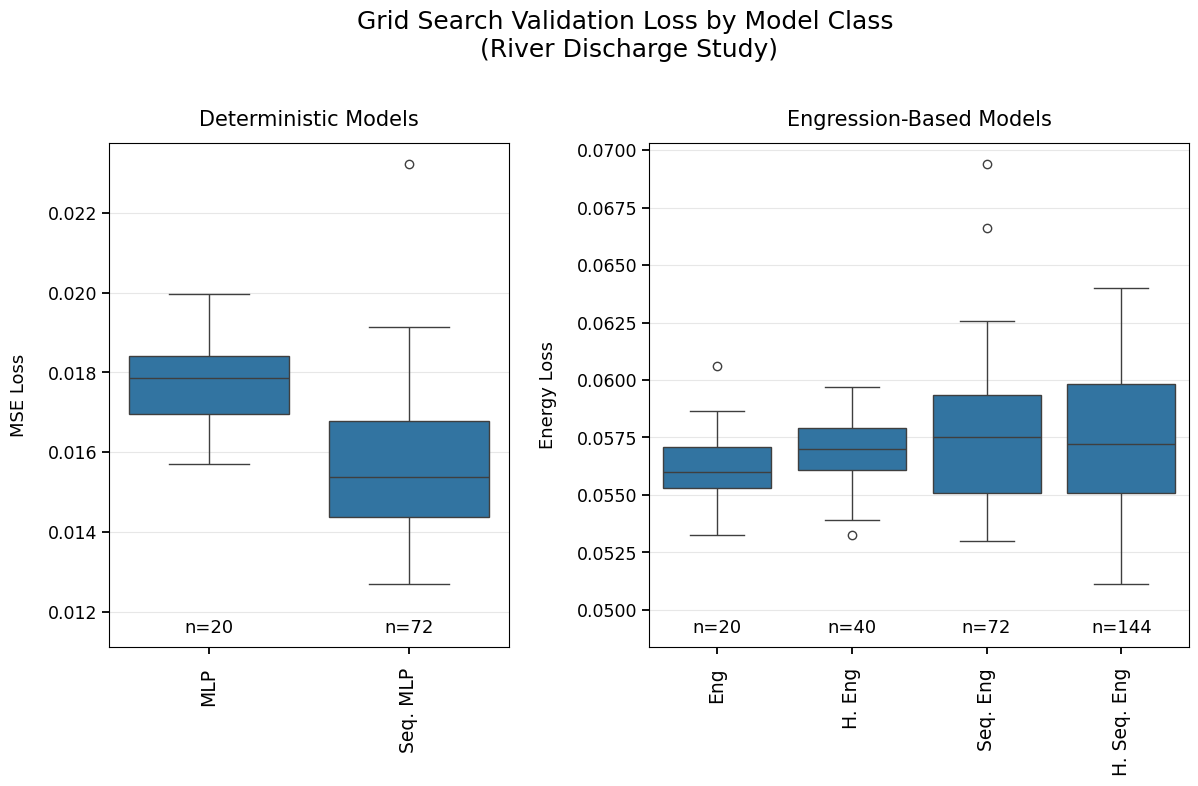

In [50]:
# Define model order and abbreviations for each group
mlp_group = ["mlp", "sequential_mlp"]
mlp_labels = {"mlp": "MLP", "sequential_mlp": "Seq. MLP"}

engression_group = [
    "engression",
    "h_engression",
    "sequential_engression",
    "h_sequential_engression"
]
engression_labels = {
    "engression": "Eng",
    "h_engression": "H. Eng",
    "sequential_engression": "Seq. Eng",
    "h_sequential_engression": "H. Seq. Eng"
}

# Prepare data for each group and map abbreviations
mlp_df = full_sim_rd[full_sim_rd["model"].isin(mlp_group)].copy()
mlp_df["model"] = pd.Categorical(mlp_df["model"], categories=mlp_group, ordered=True)
mlp_df["model_abbr"] = mlp_df["model"].map(mlp_labels)

engression_df = full_sim_rd[full_sim_rd["model"].isin(engression_group)].copy()
engression_df["model"] = pd.Categorical(engression_df["model"], categories=engression_group, ordered=True)
engression_df["model_abbr"] = engression_df["model"].map(engression_labels)

fig, axs = plt.subplots(
    1, 2, figsize=(12, 7),
    sharey=False,
    gridspec_kw={'width_ratios': [1, 1.35], 'wspace': 0.3}
)

# Adjust y-axis limits for better visualization
for ax, df in zip(axs, [mlp_df, engression_df]):
    if not df.empty:
        ymin = df['best_val'].min()
        ymax = df['best_val'].max()
        yrange = ymax - ymin if ymax > ymin else 1e-4
        ax.set_ylim(ymin - 0.15 * yrange, ymax + 0.05 * yrange)

# Left: MLP and Sequential MLP
sns.boxplot(data=mlp_df, x="model_abbr", y="best_val", ax=axs[0])
axs[0].set_title("Deterministic Models", fontsize=15, pad=12)
axs[0].set_xlabel("", fontsize=13, labelpad=8)
axs[0].set_ylabel("MSE Loss", labelpad=14, fontsize=13)
axs[0].tick_params(axis='x', labelrotation=90, labelsize=14, pad=10)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].grid(True, axis='y', alpha=0.3)
axs[0].tick_params(labelsize=12)

# Right: Engression models
sns.boxplot(data=engression_df, x="model_abbr", y="best_val", ax=axs[1])
axs[1].set_title("Engression-Based Models", fontsize=15, pad=12)
axs[1].set_xlabel("", fontsize=13, labelpad=8)
axs[1].set_ylabel("Energy Loss", labelpad=14, fontsize=13)
axs[1].tick_params(axis='x', labelrotation=90, labelsize=14, pad=10)
axs[1].tick_params(axis='y', labelsize=12)
axs[1].grid(True, axis='y', alpha=0.3)
axs[1].tick_params(labelsize=12)


# Add counts under each box
for ax, df in zip(axs, [mlp_df, engression_df]):
    counts = df.groupby("model_abbr", observed=True).size()
    y0 = ax.get_ylim()[0]
    offset = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.02
    for i, (cat, n) in enumerate(counts.items()):
        ax.text(i, y0 + offset, f"n={n}", 
                ha="center", va="bottom", fontsize=13, color="black")
        
# Adjust tick parameters for better visibility
for ax in axs:
    ax.tick_params(axis='x', which='major', labelrotation=90,
                   labelsize=13.5, pad=10, width=1.3, length=5)
    ax.tick_params(axis='y', which='major',
                   labelsize=12.5, width=1.3, length=5)        

fig.suptitle("Grid Search Validation Loss by Model Class\n (River Discharge Study)", fontsize=18, y=0.99)

plt.subplots_adjust(left=0.07, right=0.97, top=0.80, bottom=0.08, wspace=0.35)
plt.savefig("grid_search_river.pdf", bbox_inches='tight', dpi=600)
plt.show()